In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#1.PREPROCESS - CLEANING


In [ ]:
import numpy as np
import pandas as pd
#Source: https://eightportions.com/datasets/Recipes/#fn:1
data1 = pd.DataFrame.transpose(pd.read_json("/content/drive/MyDrive/Colab files/recipes_raw_nosource_ar.json"))
data2 = pd.DataFrame.transpose(pd.read_json("/content/drive/MyDrive/Colab files/recipes_raw_nosource_epi.json"))
data3 = pd.DataFrame.transpose(pd.read_json("/content/drive/MyDrive/Colab files/recipes_raw_nosource_fn.json"))



### 1.1 Clean data2 from duplicate instructions

In [ ]:
#Instructions in data2 are all duplicates, where the instructions is written on a single line or with newline. 
#Below function is used to clean this.
def removeDuplicates(df):
  count = 0
  for row in df.itertuples():
    cleaned = row.instructions.split('\n', 1)
    
    if len(cleaned) > 1:
      df.at[row.Index, "instructions"] = cleaned[1] #Keeps the instructions with newline for each new instruction. One-line instruction is at cleaned[0]
      count += 1

  print("Total Recipes from data2: " + str(len(df)))
  print("Duplicates Cleaned from data2: " + str(count))
  df = df[["title", "ingredients", "instructions"]]
  return df
data2 = removeDuplicates(data2.copy())

Total Recipes from data2: 25323
Duplicates Cleaned from data2: 25300


### 1.2 Merge the three datasets into one.

In [ ]:
df_merged = pd.concat([data1, data2, data3])

### 1.3 Removes recipes containing NaN values & Dropping picture link column

In [ ]:
def requiredFields(df):
    required_fields = ["title", "ingredients", "instructions"]
    
    for field in required_fields:
        df.drop(df.loc[df[field].isnull() == True].index, axis=0, inplace=True)
    df.drop("picture_link", inplace=True, axis=1)
    return df


df_cleaned = requiredFields(df_merged.copy())
print(len(df_merged))
print(len(df_cleaned))
print(str(len(df_merged)-len(df_cleaned)) + " " + "NaN recipes removed from the dataset")

125164
124473
691 NaN recipes removed from the dataset


### 1.4 Function to remove sentences beginning with "Photograph by..."
The picture-link column was dropped in 1.3, but some recipes still contains the photographers name in their ingredient and instruction section.


In [ ]:
stop = ["Instructions", "▪︎"]

photograph_count = 0

def findNames(recipe): #Sentences like "photograph by antonis achilleos" appears all over the dataset. Remove this.
    global photograph_count
    new = recipe.lower().split()

    if "photograph" in new:
        idx_from = new.index("photograph")
        recipe_idx_from = recipe.index("photograph")
        for word in new[idx_from:]:
            if word in stop:
              break
            if new.index(word) == len(new)-1:
              break
            end_word = word
            
        recipe_idx_to = recipe.find(end_word, recipe_idx_from)
        recipe_idx_to = recipe.find(" ", recipe_idx_to)
        photograph_count += 1
        return([recipe_idx_from, recipe_idx_to])
    return None



### 1.5 Clean units in parathesis
Sometimes two units is given e.g. 2 (10 ounces) cans of.

In [ ]:
def removeParanthesis(ing): 
    new_ing = []
    s = re.findall('\(([^)]+)', ing)
    for words in s:
        ing = ing.replace(words, "").replace("()", "").replace("  ", " ").replace(" .", ".")
        
    return ing
    

### 1.6 Convert the dataframe into a list of strings

In [ ]:
#####################################################REWRITE THIS###############################################################
STOP_WORD_TITLE = 'Title'
STOP_WORD_INGREDIENTS = '\nIngredients\n'
STOP_WORD_INSTRUCTIONS = '\nInstructions\n'
import re

def recipe_to_string(recipe):
    remove_string = 'ADVERTISEMENT'
    
    title = recipe.title
    ingredients = recipe.ingredients
    instructions = recipe.instructions.split('\n')
        
    ingredients_string = ''
    for ingredient in ingredients:
        ingredient = ingredient.replace(remove_string, '')
        ingredient = ingredient.replace(';', '')
        ingredient = ingredient.replace(":", '')
        if ingredient:
            ingredients_string += f'• {ingredient}\n'
    
    instructions_string = ''
    for instruction in instructions:
        instruction = instruction.replace(remove_string, '')
        instruction = instruction.replace(';', '')
        instruction = instruction.replace(":", '')
        if instruction:
            instructions_string += f'▪︎ {instruction}\n'
    
    ingredients_string = removeParanthesis(ingredients_string).lower()
    instructions_string = removeParanthesis(instructions_string).lower()
    title = title.lower()
    
    new_recipe = f'{STOP_WORD_TITLE} {title}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}'
    
    photograph_by = findNames(new_recipe)
    
    if photograph_by is not None:
        new_recipe = new_recipe[:photograph_by[0]-3] + new_recipe[photograph_by[1]:]

    return new_recipe

In [ ]:
photograph_count = 0
df_string = [recipe_to_string(recipe) for recipe in df_cleaned.itertuples()]
print("\"Photograph by...\" strings removed from: " + str(photograph_count) + " recipes")
print("Total number of recipes: " + str(len(df_string)))


"Photograph by..." strings removed from: 4220 recipes
Total number of recipes: 124473


### 1.7 Removing trademark/copyright/reserved recipes
This makes sure that only ingredients is used, and not for example a specific brand of an ingredient. Example below: "pure leaf™"

In [ ]:
for i in df_string[40000:]:
    if "™" in i:
        print(i)
        break

Title crispy garlic-parmesan chicken

Ingredients
• 4 boneless skinless chicken breasts
• 1/4 cup butter, melted
• 1 can progresso™ recipe starters™ creamy parmesan basil cooking sauce
• 1/4 teaspoon garlic powder
• 2/3 cup progresso® italian style panko crispy bread crumbs
• 2/3 cup finely shredded parmesan or asiago cheese
• hot cooked pasta or mashed potatoes, if desired
• garnishes, if desired
• additional shredded parmesan or asiago cheese
• chopped fresh basil or parsley

Instructions
▪︎ 1. heat oven to 400 degrees f. line cookie sheet with foil spray with cooking spray. between pieces of plastic wrap or waxed paper, place each chicken breast smooth side down gently pound with flat side of meat mallet or rolling pin until about 1/2 inch thick. sprinkle chicken with salt and pepper to taste.
▪︎ 2. in shallow dish, mix butter, 3 tablespoons of the cooking sauce and the garlic powder. in another shallow dish, mix bread crumbs and cheese. dip chicken into butter mixture, then dip int

In [ ]:
trademark = ("®", "™", "©")

def filterTrademarkRecipes(df):
  df_new = []
  for idx, recipe in enumerate(df):
    if not any(word in recipe for word in trademark):
      df_new.append(recipe)
  return df_new

df_string_new = filterTrademarkRecipes(df_string)
print("Number of recipes containing trademark/copyright/reserved removed: " + str(len(df_string) - len(df_string_new)))

Number of recipes containing trademark/copyright/reserved removed: 3701


### 1.8 Filter recipes by length
This is to reduce the sample size (due to hardware limitations), but also to remove outliers. Most recipes seems to be between 75-300 words.

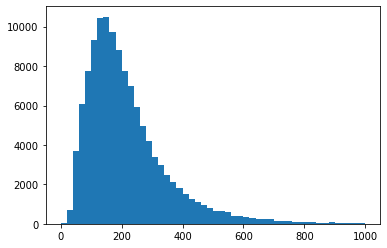

In [ ]:
import matplotlib.pyplot as plt
recipes_lengths = [len(string.split()) for string in df_string_new]

plt.hist(recipes_lengths, range=(0, 1000), bins=50)
plt.show()

In [ ]:
import math
import random
MIN_LENGTH = 75
MAX_LENGTH = 300

def filterRecipes(df):
    filtered_df = []
    for recipe in df:
        if len(recipe.split()) < MAX_LENGTH and len(recipe.split()) > MIN_LENGTH:
            filtered_df.append(str(recipe))

    return filtered_df

df_filtered = filterRecipes(df_string.copy())
print("Recipes before filtering: " + str(len(df_string)))
print("Recipes after filtering:  " + str(len(df_filtered)))

#df_filtered = resizeDataFrame(df_filtered, math.floor(len(df_filtered)/1000)*1000) #Shrink to nearest 1000.
#print("df filtered length after shrink: " + str(len(df_filtered)))

Recipes before filtering: 124473
Recipes after filtering:  91011


### 1.9 Resize dataset to be dividable by the BATCH_SIZE.
This function is used since RNN (LSTM, GRU etc.) requires a fixed batch size. 
The batch size should be a proper division of the df size. Therefore we need to find a df size that can be perfectly divided into equal-sized batches.

In [ ]:
BATCH_SIZE = 64

def resizeDataFrame(df, batch_size):
    print("Before shrinking: " + str(len(df)))
    for i in df:
        if len(df) % batch_size == 0: 
            break
        else:
            df.remove(i)
    print("After shrinking:  "+ str(len(df)))
    print("# batches of size " + str(batch_size) + ": " + str(int(len(df)/batch_size)))
    return df

In [ ]:
df_filtered = resizeDataFrame(df_filtered, BATCH_SIZE) #Shrink to nearest 1000.

Before shrinking: 91011
After shrinking:  91008
# batches of size 64: 1422


In [ ]:
import pickle
with open("/content/drive/MyDrive/Colab files/df_filtered.txt", "wb") as fp:   #Pickling
     pickle.dump(df_filtered, fp)

REMOVE?? Run below to load df_filtered from previous session.

In [ ]:
'''import numpy as np
import pandas as pd
import pickle

with open("/content/drive/MyDrive/Colab files/new_df.txt", "rb") as fp:   # Unpickling
       new_df = pickle.load(fp)'''

'import numpy as np\nimport pandas as pd\nimport pickle\n\nwith open("/content/drive/MyDrive/Colab files/new_df.txt", "rb") as fp:   # Unpickling\n       new_df = pickle.load(fp)'

#2.Tokenization

In [ ]:
#Building an vocabulary
import nltk
import gensim
from nltk.tokenize import word_tokenize
nltk.download('punkt')

df_tokenized = [word_tokenize(df_filtered[idx]) for idx, _ in enumerate(df_filtered)]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#3.Vectorization

### 3.1 Training the gensim Word2Vec Model

In [ ]:
model = gensim.models.Word2Vec(df_tokenized, min_count=1)
model.wv.save('/content/drive/MyDrive/Colab files/model.bin')

### 3.1 Functions to translate vectorized recipes back to a uniform string formatting

In [ ]:
new_line = ["•", "▪︎"]
headers = ["Ingredients", "Instructions"]
punctuation = [".", ","]
paranthesis = ["(", ")"]
    
def word2idx(word):
    return model.wv.vocab[word].index

def idx2word(idx):
    return model.wv.index2word[idx]

def indices2sentences(sentence): #Converts a vectorized recipe back to a unifrom string formatting.
    s = ""
    prev_title = False
    for idx in sentence:
        if idx2word(idx) in headers:
            s+= "\n\n" + str(idx2word(idx))
        elif idx2word(idx) in new_line:
            s+= "\n" + str(idx2word(idx))
        elif idx2word(idx) == "Title":
            s+= "\n" + str(idx2word(idx)) + " "
            prev_title = True
        else:
            if idx2word(idx) not in punctuation and not prev_title:
                s+= " " + str(idx2word(idx)) 
            else:
                s+= str(idx2word(idx))
                prev_title = False
    s = re.sub(r'(\s([?,.!"]))|(?<=\[|\()(.*?)(?=\)|\])', lambda x: x.group().strip(), s)

    return(s)

### 3.3 Vectorize recipes

In [ ]:
#Vectorizes each token in each recipe creating the new df_vec
df_vec = []
for recipe in df_tokenized:
    current_recipe = []
    for word in recipe:
        current_recipe.append(word2idx(word))
    df_vec.append(current_recipe)

### 3.4 Padding to vectorized recipes

In [ ]:
import tensorflow as tf
df_padded = tf.keras.preprocessing.sequence.pad_sequences(df_vec, padding="post", maxlen=MAX_LENGTH+1)
print(len(df_padded))

91008


#### 3.4.1 Test to see if padding and translation works

In [ ]:
print(indices2sentences(df_padded[5020]))
print("\n")
print(df_padded[5020])


Title easy garlic-lemon scallops

Ingredients
• 3/4 cup butter
• 3 tablespoons minced garlic
• 2 pounds large sea scallops
• 1 teaspoon salt
• 1/8 teaspoon pepper
• 2 tablespoons fresh lemon juice

Instructions
▪︎ melt butter in a large skillet over medium-high heat. stir in garlic, and cook for a few seconds until fragrant. add scallops, and cook for several minutes on one side, then turn over, and continue cooking until firm and opaque.
▪︎ remove scallops to a platter, then whisk salt, pepper, and lemon juice into butter. pour sauce over scallops to serve.,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


[  27  933 8524  759   28    1  107   11   38    1   36   25  130   46
    1   12  223   33  476  759    1    5   20   17    1  403   20   18
    1   12   25   55   73   64   29    8  273   38    9    7   33   77
   30  198   21    2   42  

# 4.Prepare data for training


### 4.1 CHECK THIS! Creates a dataset with one element for each row in the input tensor.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(df_padded)
print(dataset)

<TensorSliceDataset shapes: (301,), types: tf.int32>


### 4.2 Define variables for training

In [ ]:
#model2 = gensim.models.KeyedVectors.load("model.bin")
BATCH_SIZE = 64 #Takes 64 recipes per batch
BUFFER_SIZE = 1000
vocab_size = len(model.wv.vocab) + 1 #1 added since the indexing of arrays is zero-offset.
print("Vocabylary size: " + str(vocab_size))
embedding_dim = 256
rnn_units = 512

Vocabylary size: 44288


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


### 4.3 Define input and target recipes

In [ ]:
#REWRITE THIS!
#RETURNS 299 instead of 300. Do I need to add +1 to previous padding?
def inputTarget(recipe):
    input_recipe = recipe[:-1]
    target_recipe = recipe[1:]
    print(len(input_recipe))
    return input_recipe, target_recipe
    
df_target = dataset.map(inputTarget)
print(df_target)

300
<MapDataset shapes: ((300,), (300,)), types: (tf.int32, tf.int32)>


### 4.4 Shuffle and split dataset to batches
This will be our training dataset

In [ ]:
#Splitting dataset to batches
df_train = df_target.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()
print(type(df_train))

<class 'tensorflow.python.data.ops.dataset_ops.RepeatDataset'>


### 4.5 Build the model

In [ ]:
import tensorflow as tf
#Function from https://www.tensorflow.org/tutorials/text/text_generation
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True),
        tf.keras.layers.Dense(vocab_size) #Lägg tilll activation="softmax"? Ensures outputs have the characteristics of normalized probabilities.
    ])
    return model

gru_model = build_model(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units, batch_size=BATCH_SIZE)

In [ ]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           11337728  
_________________________________________________________________
gru (GRU)                    (64, None, 512)           1182720   
_________________________________________________________________
dense (Dense)                (64, None, 44288)         22719744  
Total params: 35,240,192
Trainable params: 35,240,192
Non-trainable params: 0
_________________________________________________________________


### 4.6 Define loss function and Optomizer algorithm

In [ ]:
import tensorflow as tf
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true=labels, y_pred=logits, from_logits=True)
    return entropy

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

### 4.7 Compiling the model

In [ ]:
gru_model.compile(optimizer=adam_optimizer, loss=loss, metrics=['accuracy'])
gru_model.save('/content/drive/MyDrive/Colab files/recipe_model_pre_fit.h5')

### 4.8 Defining early stopping to avoid overfitting.

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1)

### 4.9 Create checkpoints to save the latest trained model after each epoch.

In [ ]:
import os
# Create a checkpoints directory.

checkpoint_dir = '/content/drive/MyDrive/Colab files/tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'model_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

NameError: ignored

#### Define fitting variables

In [ ]:
EPOCHS = 30
INITIAL_EPOCH = 17 #Change if loading from checkpoint and last successful epoch. 
STEPS_PER_EPOCH = len(df_padded)/BATCH_SIZE#Batch_size*steps = number of recipes per epoch. Should a value where batch_size*step = len(total_samples)

#Load below if interrupted to proceed from defined initial_epoch.
#gru_model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

Checks that gpu is used.

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
for input, target in df_train.take(1):
    predictions = model(input)
    print(predictions.shape, "# (batch_size, sequence_length, vocab_size)")

# 5.Fit the model

In [ ]:
history = gru_model.fit(
    x=df_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = '/content/drive/MyDrive/Colab files/recipe_model.h5'
gru_model.save(model_name, save_format='h5')

Epoch 18/30
1422/1422 [==============================] - 1926s 1s/step - loss: 1.0249 - accuracy: 0.5782
Epoch 19/30
1422/1422 [==============================] - 1925s 1s/step - loss: 1.0171 - accuracy: 0.5804
Epoch 20/30
1422/1422 [==============================] - 1924s 1s/step - loss: 1.0098 - accuracy: 0.5825
Epoch 21/30
1422/1422 [==============================] - 1922s 1s/step - loss: 1.0032 - accuracy: 0.5845
Epoch 22/30
1422/1422 [==============================] - 1923s 1s/step - loss: 0.9971 - accuracy: 0.5864
Epoch 23/30
1422/1422 [==============================] - 1919s 1s/step - loss: 0.9913 - accuracy: 0.5881
Epoch 24/30
1422/1422 [==============================] - 1918s 1s/step - loss: 0.9859 - accuracy: 0.5898
Epoch 25/30
1422/1422 [==============================] - 1919s 1s/step - loss: 0.9809 - accuracy: 0.5913
Epoch 26/30
1422/1422 [==============================] - 1918s 1s/step - loss: 0.9763 - accuracy: 0.5927
Epoch 27/30
1422/1422 [==============================] 

### 5.1 Loss plot

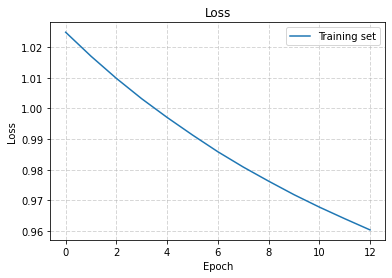

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [ ]:
from keras.models import load_model
import gensim
import tensorflow as tf

gru_model = load_model('/content/drive/MyDrive/Colab files/recipe_generation_rnn_raw_long_1size.h5', compile=False)
model = gensim.models.KeyedVectors.load("/content/drive/MyDrive/Colab files/model.bin")

#New values
pred_batch_size = 1
vocab_size = len(model.vocab) + 1 #1 added since the indexing of arrays is zero-offset.
embedding_dim = 256
rnn_units = 512

#Load weigths from full model.
old_weights = gru_model.get_weights()

model_prediction = build_model(vocab_size, embedding_dim, rnn_units, pred_batch_size)

#If model successfully train load weights from model.
#model_prediction.set_weights(old_weights)

#If training interrupted. Load weights from checkpoint.
#model_prediction.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model_prediction.build(tf.TensorShape([pred_batch_size, None]))

model_prediction.save('/content/drive/MyDrive/Colab files/model_prediction.h5', save_format='h5')
model_prediction.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            11337728  
_________________________________________________________________
gru_2 (GRU)                  (1, None, 512)            1182720   
_________________________________________________________________
dense_2 (Dense)              (1, None, 44288)          22719744  
Total params: 35,240,192
Trainable params: 35,240,192
Non-trainable params: 0
_________________________________________________________________


##Run recipe_generator_run to genererate and evaluate the recipes